In [309]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from numba import jit, njit, prange
from numba import config

start_time = time.time()

# Parameter
L = 512           # Lattice size LxL
T = 1        # Temperature - critical temperature is around 2.269
J = 1                 # Coupling constant (J > 0 for ferromagnetic interaction)
steps = int(512*1)            # Number of Monte Carlo steps
k_B = 1      # Boltzmann constant
H = 0              # External magnetic field
np.random.seed(42) # Set seed for reproducibility

# Initialize the lattice (random spins +1 or -1)
@jit(nopython=True)
def initialise_lattice(L):
    # Generate a random lattice of 0s and 1s and map them to -1 and 1
    lattice = 2 * np.random.randint(0, 2, size=(L, L)) - 1
    return lattice

# Calculate the magnetisation for a spin configuration
@jit(nopython=True)
def calc_mag(lattice):
    return np.sum(lattice)

@jit(nopython=True)
def sum_neighbours(lattice,i,j):
    return lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]

# Calculate energy for a spin configuration
@jit(nopython=True)
def calc_energy(lattice):
    energy = 0
    L = lattice.shape[0]
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            neighbours = sum_neighbours(lattice,i,j)
            energy += -J * S * neighbours / 2  # Each connection between neighbours is counted twice so / 2

    energy -= H * np.sum(lattice) # this is -h sum s_i
    return energy

# Monte Carlo step using Metropolis algorithm
@jit(nopython=True)
def monte_carlo_step(lattice, T):
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)
        S = lattice[i, j]
        # Calculate the energy difference if the spin is flipped
        neighbours = sum_neighbours(lattice,i,j)
        delta_E = 2 * J * S * neighbours
        # Metropolis criterion
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (k_B * T)):
            lattice[i, j] *= -1

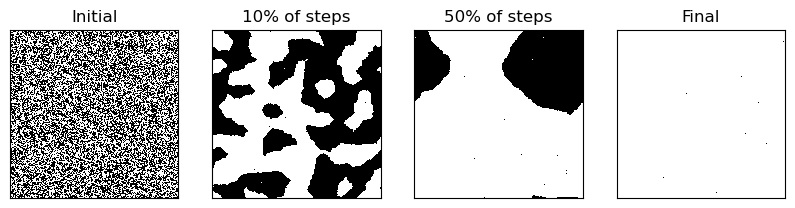

In [ ]:
@jit(nopython = True, parallel=True)
def monte_carlo_step_checkerboard(lattice, T, J=1.0, k_B=1.0):
    L = lattice.shape[0]

    # Update black spins
    for i in prange(L):
        for j in range(L):
            if (i + j) % 2 == 0:  # Black spins
                S = lattice[i, j]
                neighbours = (lattice[(i+1) % L, j] + lattice[(i-1) % L, j] +
                              lattice[i, (j+1) % L] + lattice[i, (j-1) % L])
                delta_E = 2 * J * S * neighbours
                if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (k_B * T)):
                    lattice[i, j] *= -1

    # Update white spins
    for i in prange(L):
        for j in range(L):
            if (i + j) % 2 == 1:  # White spins
                S = lattice[i, j]
                neighbours = (lattice[(i+1) % L, j] + lattice[(i-1) % L, j] +
                              lattice[i, (j+1) % L] + lattice[i, (j-1) % L])
                delta_E = 2 * J * S * neighbours
                if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (k_B * T)):
                    lattice[i, j] *= -1
                    
magnetisation = np.zeros(steps)
energy = np.zeros(steps)
lattice = initialise_lattice(L)
lattice_histories = []

config.NUMBA_NUM_THREADS = 1

for i in range(steps):
    monte_carlo_step_checkerboard(lattice, T)
    # monte_carlo_step(lattice, T)

    magnetisation[i] = calc_mag(lattice)/L**2
    energy[i] = calc_energy(lattice)/L**2
    lattice_histories.append(lattice.copy())

def plot_lattice(lattice, title):
    plt.imshow(lattice, cmap='gray', interpolation='none', vmin=-1, vmax=1)  
    plt.title(title)
    # plt.colorbar(label='Spin')

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

# Plot the "before" state
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)  # Create subplot for the "before" state
plot_lattice(lattice_histories[0], 'Initial')

# Plot the "after" state
plt.subplot(1, 4, 2)  # Create subplot for the "after" state
plot_lattice(lattice_histories[round(steps/10)], '10% of steps')

# Plot the "after" state
plt.subplot(1, 4, 3)  # Create subplot for the "after" state
plot_lattice(lattice_histories[round(steps/2)], '50% of steps')

# Plot the "after" state
plt.subplot(1, 4, 4)  # Create subplot for the "after" state
plot_lattice(lattice, 'Final')

plt.show()


In [296]:
# Main simulation

# Initialize the lattice


sims = 1
store = []
temps = [1]
# temps = [1]

# Perform the simulation
for Temp in temps:
    T = Temp
    for j in range(sims):
        
        lattice = initialise_lattice(L)
        magnetisation = np.zeros(steps)
        energy = np.zeros(steps)
        lattice_histories = []

        for i in range(steps):
            monte_carlo_step(lattice, T)
            magnetisation[i] = calc_mag(lattice)/L**2
            energy[i] = calc_energy(lattice)/L**2
            lattice_histories.append(lattice.copy())
            if np.var(magnetisation[i-64:i]) < 1e-6:
                print(i)

        store.append(energy)


    

c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

# Plot magnetisation

Text(0.5, 1.0, 'Energy per step vs MC steps for 8 runs')

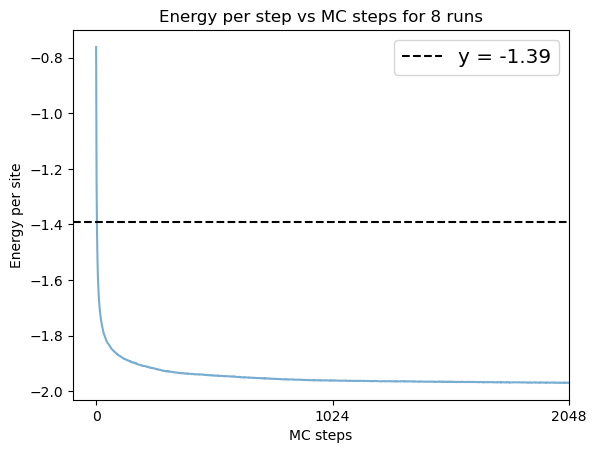

In [276]:
# Plot the magnetisation and energy

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)  # Create subplot for the magnetisation
# plt.plot(magnetisation)
# plt.xlabel('MC steps')
# plt.ylabel('Magnetisation')
# plt.title('Magnetisation vs MC steps')

# plt.subplot(1, 2, 2)  # Create subplot for the energy
for i in range(sims*len(temps)):
    plt.plot(store[i], alpha=0.6)
#put line at y = -1.4
plt.axhline(y=-1.39, color='black', linestyle='--', label = f"y = -1.39")
plt.xlabel('MC steps')
plt.ylabel('Energy per site')
plt.xticks(range(0, len(store[0]) + 1, 1024))  # Set x-axis ticks in steps of 1024
plt.xlim(-100,steps)
plt.legend(fontsize = "x-large")
plt.title('Energy per step vs MC steps for 8 runs')




In [272]:
# Find mean value between step 1000 and 2000

mean_energy = []

for i in range(sims):
    mean_energy.append(np.mean(store[i][1024:,]))
    print(mean_energy)
overall = np.mean(mean_energy)


mean_energy = np.mean(store[0][1024*2:,])
print(energy[1024])
print(mean_energy)
print(overall)

# print(np.mean(store[5][1024:,]))

[-1.9647498726844788]
-1.9576873779296875
nan
-1.9647498726844788


c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Different Temps

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.8500000000000005
4.9
4.95
5.0


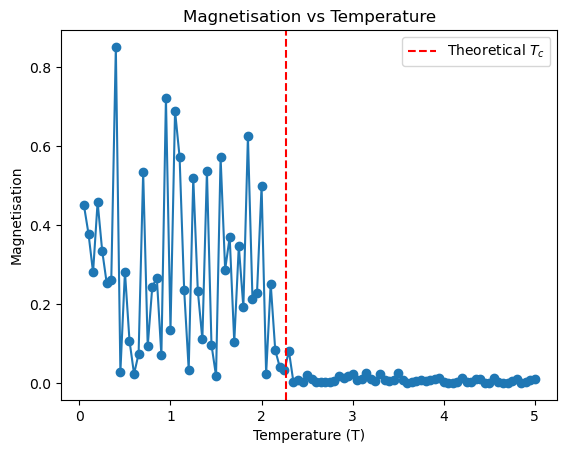

In [219]:
# Simulate for different temperatures
temperatures = np.linspace(0.05, 5, 100)
magnetizations = []

L = 256
steps = 2048

for T in temperatures:
    # Initialize the lattice
    print(T)
    lattice = initialise_lattice(L) 
    
    # Run the simulation
    for step in range(steps):
        monte_carlo_step(lattice, T)
    
    # After thermalization, calculate the average magnetization
    mag = np.abs(calc_mag(lattice)) / (L * L)  # Normalize by number of spins
    magnetizations.append(mag)

# Plot results
plt.plot(temperatures, magnetizations, '-o')
plt.axvline(x=2.269, color='r', linestyle='--', label="Theoretical $T_c$")
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetisation")
plt.title("Magnetisation vs Temperature")
plt.legend()
plt.show()

In [218]:
temperatures = np.linspace(0.05, 5, 100)
print(temperatures)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1
 2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8
 2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45 3.5
 3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2
 4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9
 4.95 5.  ]


In [220]:
# save themagnetisation

np.save("magnetisations", magnetizations)

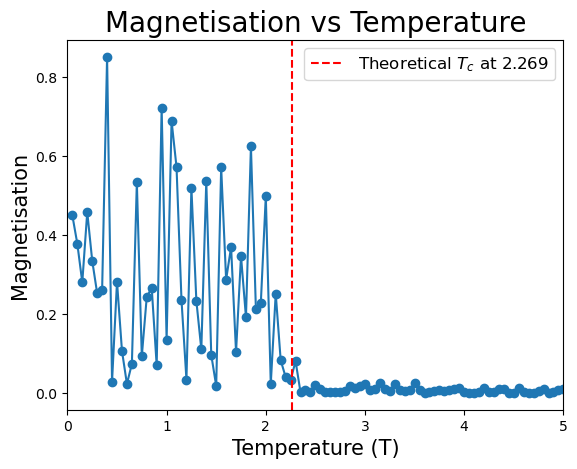

In [229]:
plt.plot(temperatures, magnetizations, '-o')
plt.axvline(x=2.269, color='r', linestyle='--', label="Theoretical $T_c$ at 2.269")
plt.xlabel("Temperature (T)", fontsize = 15)
plt.ylabel("Magnetisation", fontsize = 15)
plt.title("Magnetisation vs Temperature", fontsize = 20)
plt.xlim(0,5)
plt.legend(fontsize = "large")
plt.ion()
plt.show()

In [228]:
new  = np.load("magnetisations.npy")

print(new)

[4.49768066e-01 3.77899170e-01 2.80151367e-01 4.58312988e-01
 3.35235596e-01 2.52563477e-01 2.60803223e-01 8.51165771e-01
 2.85644531e-02 2.81829834e-01 1.06872559e-01 2.28881836e-02
 7.37915039e-02 5.33782959e-01 9.29870605e-02 2.43652344e-01
 2.65930176e-01 6.99768066e-02 7.22503662e-01 1.35223389e-01
 6.89208984e-01 5.72174072e-01 2.35900879e-01 3.38745117e-02
 5.19287109e-01 2.33306885e-01 1.10534668e-01 5.36834717e-01
 9.66491699e-02 1.80664062e-02 5.71563721e-01 2.87170410e-01
 3.69659424e-01 1.03576660e-01 3.46740723e-01 1.91864014e-01
 6.24694824e-01 2.13684082e-01 2.28942871e-01 4.99084473e-01
 2.23999023e-02 2.51708984e-01 8.30993652e-02 4.02221680e-02
 3.24096680e-02 8.08410645e-02 1.64794922e-03 8.23974609e-03
 2.89916992e-03 1.92565918e-02 1.03759766e-02 2.13623047e-03
 3.08227539e-03 1.49536133e-03 3.47900391e-03 5.98144531e-03
 1.76696777e-02 1.21154785e-02 1.87683105e-02 2.21252441e-02
 6.50024414e-03 9.12475586e-03 2.56042480e-02 1.00708008e-02
 3.99780273e-03 2.203369